In [83]:
import astropy.io.fits as fits
from astropy.table import Table
import numpy as np
import desispec.io
import desispec.tpcorrparam
import os
import matplotlib.pyplot as plt


In [84]:
def process_tpcorr(specprod, output_dir="./", num_exposures=None):
    """
    Process TPCORR data for a given specprod.

    Args:
        specprod (str): The specprod identifier.
        output_dir (str, optional): Directory to save the output file. Defaults to current directory.
        num_exposures (int, optional): Number of exposures to process. If None, process all exposures.

    Returns:
        dict: A dictionary containing the processed TPCORR data.
    """
    # Set environment variable
    os.environ['SPECPROD'] = specprod

    # Define the exposures table
    exp_file = os.path.join(os.environ.get('DESI_SPECTRO_REDUX'), specprod, f'exposures-{specprod}.csv')
    
    # Read exposures
    exps = Table.read(exp_file)
    
    # Limit number of exposures if specified
    if num_exposures is not None:
        exps = exps[:num_exposures]

    # Gather the data
    tpcorrdata = desispec.tpcorrparam.gather_tpcorr(exps)

    # Save the data
    output_file = os.path.join(output_dir, f'tpcorr_summary-{specprod}.fits')
    fits.writeto(output_file, tpcorrdata, overwrite=True)
    print(f"TPCORR data saved to {output_file}")

    return tpcorrdata

In [85]:
tpcorrdata = {}
for specprod in ['tpcorr2', 'tpcorr6']:
    tpcorrdata[specprod] = process_tpcorr(specprod, num_exposures=50)

INFO:sky.py:135:read_sky: iotime 0.381 sec to read sky-b0-00113396.fits.gz at 2024-08-14T11:12:01.969879
INFO:fibermap.py:339:read_fibermap: iotime 0.061 sec to read frame-b0-00113396.fits.gz at 2024-08-14T11:12:02.605807
INFO:frame.py:226:read_frame: iotime 0.644 sec to read frame-b0-00113396.fits.gz at 2024-08-14T11:12:02.615139
INFO:sky.py:135:read_sky: iotime 0.461 sec to read sky-b1-00113396.fits.gz at 2024-08-14T11:12:03.088754
INFO:fibermap.py:339:read_fibermap: iotime 0.061 sec to read frame-b1-00113396.fits.gz at 2024-08-14T11:12:03.790772
INFO:frame.py:226:read_frame: iotime 0.710 sec to read frame-b1-00113396.fits.gz at 2024-08-14T11:12:03.800237
INFO:sky.py:135:read_sky: iotime 0.346 sec to read sky-b2-00113396.fits.gz at 2024-08-14T11:12:04.167437
INFO:fibermap.py:339:read_fibermap: iotime 0.062 sec to read frame-b2-00113396.fits.gz at 2024-08-14T11:12:04.795855
INFO:frame.py:226:read_frame: iotime 0.636 sec to read frame-b2-00113396.fits.gz at 2024-08-14T11:12:04.804774
I

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot_tpcorr_difference(tpcorrdata, specprod_A, specprod_B, output_file='tpcorr_difference.png'):
    """
    Plot the difference in TPCORR values between two specprods for each camera.
    
    Args:
    tpcorrdata (dict): Dictionary containing TPCORR data for different specprods
    specprod_A (str): Name of the first specprod to compare
    specprod_B (str): Name of the second specprod to compare
    output_file (str): Name of the output file to save the plot
    """
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
    fig.suptitle(f'TPCORR Difference: {specprod_B} - {specprod_A}', fontsize=16)
    
    n_records = len(tpcorrdata[specprod_A])
    print(f"Number of records: {n_records}")
    
    cameras = ['b', 'r', 'z']
    colors = ['blue', 'red', 'green']
    
    for i_rec in range(n_records):
        data_A = tpcorrdata[specprod_A][i_rec]
        data_B = tpcorrdata[specprod_B][i_rec]
        camera = data_A['CAMERA']
        
        if camera in cameras:
            idx = cameras.index(camera)
            n = len(data_B['TPCORR'])
            ids = np.arange(n) + 1
            diff = data_B['TPCORR'] - data_A['TPCORR']
            
            axs[idx].scatter(ids, diff, alpha=0.1, color=colors[idx], s=10)
            axs[idx].set_title(f'Camera {camera.upper()}')
            axs[idx].set_xlabel('Fiber ID')
            axs[idx].set_ylim(-0.1, 0.1)  # Adjust as needed
            
            if idx == 0:
                axs[idx].set_ylabel('TPCORR Difference')
            
            # Add mean and ±3 sigma lines
            #mean_diff = np.mean(diff)
            #std_diff = np.std(diff)
            #axs[idx].axhline(y=mean_diff, color='k', linestyle='--', alpha=0.5)
            #axs[idx].axhline(y=mean_diff + 3*std_diff, color='r', linestyle=':', alpha=0.5)
            #axs[idx].axhline(y=mean_diff - 3*std_diff, color='r', linestyle=':', alpha=0.5)
    
    for ax in axs:
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.5)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot saved as {output_file}")

import numpy as np
from scipy import stats

def identify_tpcorr_outliers(tpcorrdata, specprod_A, specprod_B):
    """
    Identify outliers in TPCORR differences between two specprods.
    
    Args:
    tpcorrdata (dict): Dictionary containing TPCORR data for different specprods
    specprod_A (str): Name of the first specprod to compare
    specprod_B (str): Name of the second specprod to compare
    
    Returns:
    dict: Dictionary of outliers for each camera and global statistics
    """
    
    outliers = {'b': [], 'r': [], 'z': []}
    all_diffs = {'b': [], 'r': [], 'z': []}
    
    n_records = len(tpcorrdata[specprod_A])
    
    # First pass: collect all differences
    for i_rec in range(n_records):
        data_A = tpcorrdata[specprod_A][i_rec]
        data_B = tpcorrdata[specprod_B][i_rec]
        camera = data_A['CAMERA']
        
        if camera in outliers:
            diff = data_B['TPCORR'] - data_A['TPCORR']
            all_diffs[camera].extend(diff)
    
    # Compute global mean and standard deviation for each camera
    global_stats = {}
    for camera in ['b', 'r', 'z']:
        global_stats[camera] = {
            'mean': np.mean(all_diffs[camera]),
            'std': np.std(all_diffs[camera])
        }
    
    # Second pass: identify outliers using global statistics
    for i_rec in range(n_records):
        data_A = tpcorrdata[specprod_A][i_rec]
        data_B = tpcorrdata[specprod_B][i_rec]
        camera = data_A['CAMERA']
        
        if camera in outliers:
            diff = data_B['TPCORR'] - data_A['TPCORR']
            
            # Identify outliers using global mean and std
            z_scores = np.abs((diff - global_stats[camera]['mean']) / global_stats[camera]['std'])
            outlier_indices = np.where(z_scores > 5)[0]
            
            for idx in outlier_indices:
                outliers[camera].append({
                    'fiber_id': idx + 1,
                    'difference': diff[idx],
                    'z_score': z_scores[idx],
                    'expid': data_A['EXPID'],
                    'night': data_A['NIGHT']
                })
    
    # Add global statistics to the return value
    outliers['global_stats'] = global_stats
    
    return outliers

# Example usage:
# plot_tpcorr_difference(tpcorrdata, 'tpcorr2', 'tpcorr6', 'tpcorr_difference_plot.png')
# outliers = identify_tpcorr_outliers(tpcorrdata, 'tpcorr2', 'tpcorr6')
# 
# for camera, camera_outliers in outliers.items():
#     print(f"\nOutliers for camera {camera}:")
#     for outlier in camera_outliers:
#         print(f"  Fiber ID: {outlier['fiber_id']}, Difference: {outlier['difference']:.4f}, "
#               f"Z-score: {outlier['z_score']:.2f}, EXPID: {outlier['expid']}, NIGHT: {outlier['night']}")

Number of records: 30


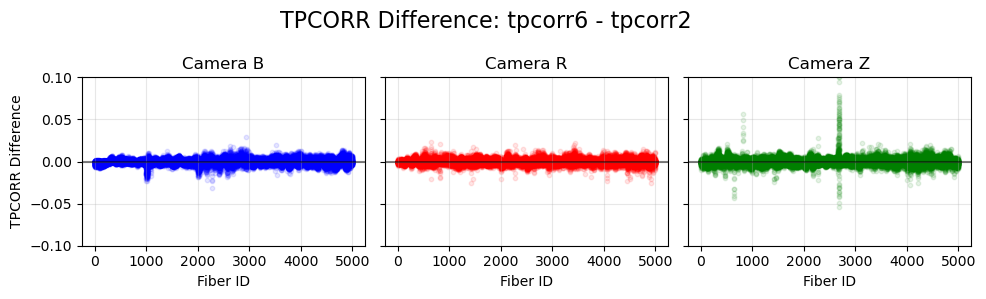

Plot saved as tpcorr_difference_plot.png


In [80]:
plot_tpcorr_difference(tpcorrdata, 'tpcorr2', 'tpcorr6', 'tpcorr_difference_plot.png')


In [73]:
outliers = identify_tpcorr_outliers(tpcorrdata, 'tpcorr2', 'tpcorr6')


In [75]:
def print_tpcorr_outliers_summary(outliers_result):
    """
    Print a summary of TPCORR outliers.

    Args:
    outliers_result (dict): The result from identify_tpcorr_outliers function
    """
    # Print global statistics
    print("Global Statistics:")
    for camera, stats in outliers_result['global_stats'].items():
        print(f"  Camera {camera}: Mean = {stats['mean']:.6f}, Std Dev = {stats['std']:.6f}")

    # Process outliers for each camera
    unique_outliers = {camera: set() for camera in ['b', 'r', 'z']}
    
    for camera in ['b', 'r', 'z']:
        camera_outliers = outliers_result[camera]
        
        # Count total outliers
        total_outliers = len(camera_outliers)
        
        # Get unique fiber IDs
        unique_outliers[camera] = set(outlier['fiber_id'] for outlier in camera_outliers)
        
        # Print summary for this camera
        print(f"\nCamera {camera}:")
        print(f"  Total number of outliers: {total_outliers}")
        print(f"  Unique outlier fiber IDs: {sorted(unique_outliers[camera])}")

        # Print some example outliers (e.g., top 5 by absolute z-score)
        if camera_outliers:
            print("  Example outliers (top 5 by absolute z-score):")
            sorted_outliers = sorted(camera_outliers, key=lambda x: abs(x['z_score']), reverse=True)[:5]
            for outlier in sorted_outliers:
                print(f"    Fiber ID: {outlier['fiber_id']}, Difference: {outlier['difference']:.4f}, "
                      f"Z-score: {outlier['z_score']:.2f}, EXPID: {outlier['expid']}, NIGHT: {outlier['night']}")

    # Print fiber IDs that are outliers across all cameras
    common_outliers = set.intersection(*unique_outliers.values())
    print("\nFiber IDs that are outliers across all cameras:")
    print(sorted(common_outliers))

    # Print total unique outliers across all cameras
    all_outliers = set.union(*unique_outliers.values())
    print(f"\nTotal unique outlier fibers across all cameras: {len(all_outliers)}")

# Usage example:
#

In [76]:
outliers_result = identify_tpcorr_outliers(tpcorrdata, 'tpcorr2', 'tpcorr6')
print_tpcorr_outliers_summary(outliers_result)

Global Statistics:
  Camera b: Mean = 0.000045, Std Dev = 0.002892
  Camera r: Mean = 0.000053, Std Dev = 0.002518
  Camera z: Mean = 0.000164, Std Dev = 0.003757

Camera b:
  Total number of outliers: 85
  Unique outlier fiber IDs: [1001, 1002, 1003, 1004, 1005, 1006, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1099, 2001, 2002, 2008, 2011, 2016, 2019, 2042, 2172, 2278, 2408, 2410, 2417, 2576, 2577, 2585, 2593, 2629, 2678, 2683, 2820, 2839, 2844, 2861, 2902, 2906, 2941, 2956, 3520, 3547, 3800]
  Example outliers (top 5 by absolute z-score):
    Fiber ID: 2278, Difference: -0.0314, Z-score: 10.87, EXPID: 113396, NIGHT: 20211211
    Fiber ID: 2941, Difference: 0.0291, Z-score: 10.04, EXPID: 113398, NIGHT: 20211211
    Fiber ID: 2278, Difference: -0.0229, Z-score: 7.94, EXPID: 113404, NIGHT: 20211211
    Fiber ID: 1014, Difference: -0.0226, Z-score: 7.85, EXPID: 113405, NIGHT: 20211211
    Fiber ID: 1002, Difference: -0.0226